# **LLM Using GEMINI API**


Processed 5 sentences out of 100
Processed 10 sentences out of 100
Processed 15 sentences out of 100
Processed 20 sentences out of 100
Processed 25 sentences out of 100
Processed 30 sentences out of 100
Processed 35 sentences out of 100
Processed 40 sentences out of 100
Processed 45 sentences out of 100
Processed 50 sentences out of 100
ValueError encountered for sentence: 'I hate Harry Potter, it's retarted, gay and stupid and there's only one Black guy...': ("Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 3. The candidate's safety_ratings are: [category: HARM_CATEGORY_SEXUALLY_EXPLICIT\nprobability: NEGLIGIBLE\n, category: HARM_CATEGORY_HATE_SPEECH\nprobability: MEDIUM\n, category: HARM_CATEGORY_HARASSMENT\nprobability: MEDIUM\n, category: HARM_CATEGORY_DANGEROUS_CONTENT\nprobability: NEGLIGIBLE\n].", [category: HA

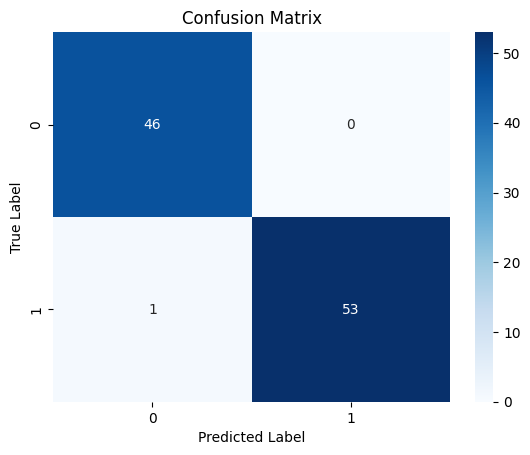

In [ ]:
import google.generativeai as genai
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time
import requests
import random

# Configure API Key
GOOGLE_API_KEY = '**********YOUR API KEY*********'
genai.configure(api_key=GOOGLE_API_KEY)
genai_model = genai.GenerativeModel('gemini-pro')

# Load dataset
data = pd.read_csv('/content/Sentiment Analysis.csv')
data = data.sample(n=100, random_state=1)  # Sample data for testing

# Few-shot examples
examples = [
    ("Ok brokeback mountain is such a horrible movie.", "0"),
    ("Brokeback Mountain was so awesome.", "1"),
    ("friday hung out with kelsie and we went and saw The Da Vinci Code SUCKED!!!!!", "0"),
    ("I am going to start reading the Harry Potter series again because that is one awesome story.", "1"),
]

# Replacement sentences for flagged inputs
replacement_sentences = [
    "This is a neutral statement.",
    "I feel indifferent about this topic.",
    "This is just an average experience.",
    "Nothing special about this situation.",
]

# Create a prompt for few-shot learning
def create_prompt(few_shot_examples, sentence):
    prompt = "Is this sentence Positive or Negative?\n\n"
    for example_sentence, category in few_shot_examples:
        prompt += f"Sentence: {example_sentence}\nCategory: {category}\n\n"
    prompt += f"Sentence: {sentence}\nCategory:"
    return prompt

# Generate predictions using the Generative AI model
def predict_sentiment(model, sentence, retries=3):
    prompt = create_prompt(examples, sentence)
    try:
        classification = model.generate_content(prompt)

        # Check if the response has a valid text
        if classification and hasattr(classification, 'text'):
            return classification.text.strip()  # Ensure lowercase prediction
        else:
            print(f"Invalid response for sentence: {sentence}")
            return "0"  # Default to "negative" on invalid response

    except requests.exceptions.RequestException as e:
        print(f"Connection error: {e}")
        if retries > 0:
            time.sleep(2 ** (3 - retries))  # Exponential backoff
            return predict_sentiment(model, sentence, retries=retries - 1)
        else:
            return "0"  # Default to "negative" on persistent failure
    except ValueError as ve:
        # Handle cases where the API raises a ValueError due to safety concerns
        print(f"ValueError encountered for sentence: '{sentence}': {ve}")

        # Replace flagged sentence with a random neutral sentence
        replacement_sentence = random.choice(replacement_sentences)
        print(f"Replacing flagged sentence: '{sentence}' with: '{replacement_sentence}'")
        return predict_sentiment(model, replacement_sentence)  # Retry with the replacement

# Loop through the dataset and generate predictions with error handling
actual_labels = data['label'].astype(str)  # Convert actual labels to string for consistency
predicted_labels = []

for i, sentence in enumerate(data['sentence']):  # Assuming 'sentence' column has the text data
    prediction = predict_sentiment(genai_model, sentence)
    predicted_labels.append(prediction)


    # Print progress every few sentences
    if (i + 1) % 5 == 0:
        print(f"Processed {i + 1} sentences out of {len(data)}")
        time.sleep(2*i+1)

# Convert predicted labels to strings
predicted_labels = [str(label) for label in predicted_labels]

# Calculate accuracy, classification report, and confusion matrix
accuracy = accuracy_score(actual_labels, predicted_labels)
class_report = classification_report(actual_labels, predicted_labels, zero_division=1)
labels = sorted(set(actual_labels))
conf_matrix = confusion_matrix(actual_labels, predicted_labels, labels=labels)

# Print results
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", class_report)
print("\nConfusion Matrix:\n", conf_matrix)

# Extract misclassified items
misclassified = data[(actual_labels != predicted_labels)]
print("Misclassified items:\n", misclassified)

# Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

